# ECE 450 - Homework #5

## Problem 7.3.1

### Part (a)

$$H(s)=\frac{s}{(s+1)(s^2+7s+10)(s+14)}$$

#### Step Response

$$e_{ss}^{step}=\frac{1}{1+\lim_{s\to 0}(\frac{s}{(s+1)(s^2+7s+10)(s+14)})}$$

$$e_{ss}^{step}=1$$

#### Ramp Response

$$e_{ss}^{ramp}=\frac{1}{\lim_{s\to 0}(s\cdot \frac{s}{(s+1)(s^2+7s+10)(s+14)})}$$

$$e_{ss}^{ramp}=\infty$$

#### Parabolic Response
 
$$e_{ss}^{parabola}=\frac{2}{\lim_{s\to 0}(s^2\cdot \frac{s}{(s+1)(s^2+7s+10)(s+14)})}$$

$$e_{ss}^{parabola}=\infty$$

### Part (b)

$$H(s)=\frac{s+5}{s(s+1)^2(s+2)(s^2+s+1)}$$

#### Step Response

$$e_{ss}^{step}=\frac{1}{1+\lim_{s\to 0}(\frac{s+5}{s(s+1)^2(s+2)(s^2+s+1)})}$$

$$e_{ss}^{step}=0$$

#### Ramp Response

$$e_{ss}^{ramp}=\frac{1}{\lim_{s\to 0}(s\cdot \frac{s+5}{s(s+1)^2(s+2)(s^2+s+1)})}$$

$$e_{ss}^{ramp}=\frac{1}{\frac{5}{(1)^2(2)(1)}}$$

$$e_{ss}^{ramp}=\frac{2}{5}$$

#### Parabolic Response

$$e_{ss}^{parabola}=\frac{2}{\lim_{s\to 0}(s^2\cdot \frac{s+5}{s(s+1)^2(s+2)(s^2+s+1)})}$$

$$e_{ss}^{parabola}=\infty$$

## Problem 7.5.1

### Package Imports


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from control import margin, tf


### Generic functions for the step, ramp, and parabolic response


In [2]:
step = lambda times:     [0 if t < 0 else 1 for t in times]
ramp = lambda times:     [0 if t < 0 else t for t in times]
parabola = lambda times: [0 if t < 0 else t * t for t in times]


### Generic function to convolve any number of equations


In [3]:
def convolve_all(values):
    temp_conv = values[0]
    if len(values) > 1:
        for next_val in values[1:]:
            temp_conv = np.convolve(temp_conv, next_val)
    
    return temp_conv


### Generic function to generate the magnitude and phase of $H(j\omega)$ values


In [113]:
def magnitude_phase_response(num, den, omega_range, omega_step=10, gain_num=None, gain_den=None):
    if isinstance(gain_num, (np.ndarray, list)) and isinstance(gain_den, (np.ndarray, list)):
        num = convolve_all([num, gain_num])
        den = convolve_all([den, gain_den])
        
    system = sig.lti(num, den)
    w, h_mag, h_phase = sig.bode(system, np.arange(omega_range[0], omega_range[1], omega_step))
    _, phase_margin, _, crossover_w = margin(h_mag, h_phase, w)
    
    df_list = []
    df = pd.DataFrame(list(zip(w, h_mag)), columns=["$\omega$", "Value"])
    df["Kind"] = "Magnitude Response"
    df_list.append(df)
    
    df = pd.DataFrame(list(zip(w, h_phase)), columns=["$\omega$", "Value"])
    df["Kind"] = "Phase Response"
    df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True, axis=0), phase_margin, crossover_w


### Generic function to obtain response of a system to inputs


In [111]:
def response_to_inputs(num, den, input_funcs, input_names, time, gain_num=None, gain_den=None):
    df_list = []
    
    # If a gain equation was given, adjust the system num / dun
    if isinstance(gain_num, (np.ndarray, list)) and isinstance(gain_den, (np.ndarray, list)):
        num = convolve_all([num, gain_num])
        den = convolve_all([den, gain_den])
    
    num = np.pad(num, (len(den) - len(num), 0), "constant") # Make arrays same length
    den = np.add(den, num)
    for in_name, in_f in zip(input_names, input_funcs):
        df = pd.DataFrame(list(zip(time, in_f(time))), columns=["Time", "Value"])
        df["Kind"] = df["Name"] = in_name
        df["Error"] = "Response"
        df_list.append(df)
        
        _, response, _ = sig.lsim((num, den), in_f(time), time)
        df = pd.DataFrame(list(zip(time, response)), columns=["Time", "Value"])
        df["Kind"] = in_name
        df["Name"] = in_name + " - Response"
        df["Error"] = "Response"
        df_list.append(df)
        
        response_err =  np.subtract(in_f(t), response)
        df = pd.DataFrame(list(zip(time, response_err)), columns=["Time", "Value"])
        df["Kind"] = in_name
        df["Name"] = in_name + " - Error"
        df["Error"] = "Error"
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True, axis=0)


### Generic function to plot the responses of a system


In [6]:
def create_plots(df, error=False):
    if error:
        sns.set(style="whitegrid", font_scale=2.25)
        g = sns.FacetGrid(df, hue="Name", row="Kind", col="Error", height=7.5, aspect=1.2, sharey=False)
        g.map(sns.lineplot, "Time", "Value", **dict(linewidth=2.5)).add_legend().despine(bottom=True, left=True)
    else:
        sns.set(style="whitegrid", font_scale=1.25)
        g = sns.FacetGrid(df, hue="Kind", row="Kind", height=5.5, aspect=1.75, sharey=False)
        g.map(sns.lineplot, "$\omega$", "Value", **dict(linewidth=2.5)).add_legend().despine(bottom=True, left=True).set(xscale="log")
    
    return g


### Part (a)


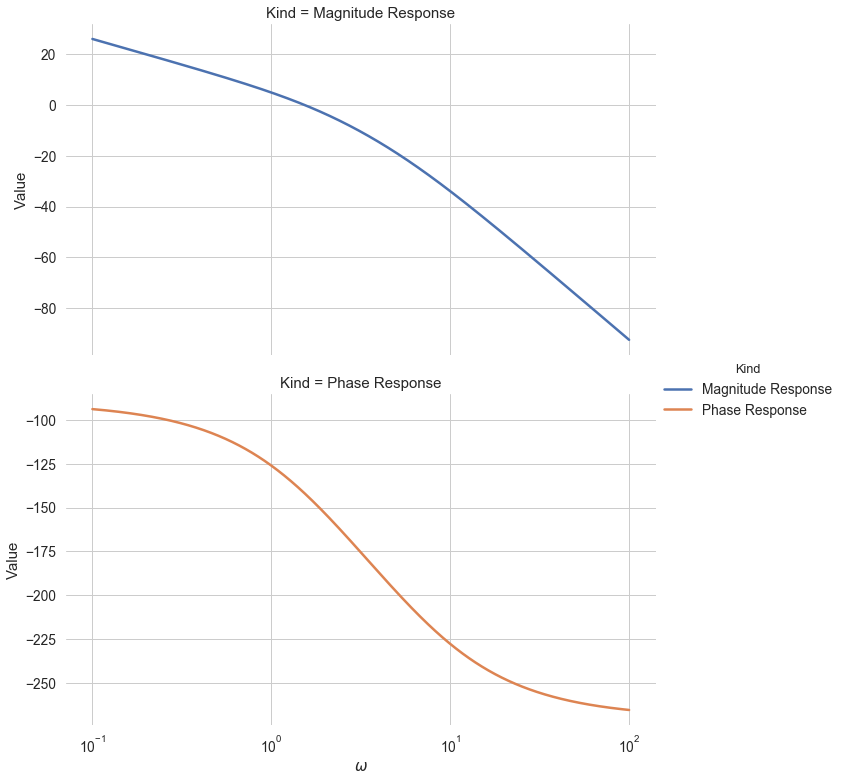

In [63]:
num = [24]
den = convolve_all([[1, 0], [1, 2], [1, 6]])

df = magnitude_phase_response(num, den, [0.1, 1e2], 0.001)
create_plots(df);

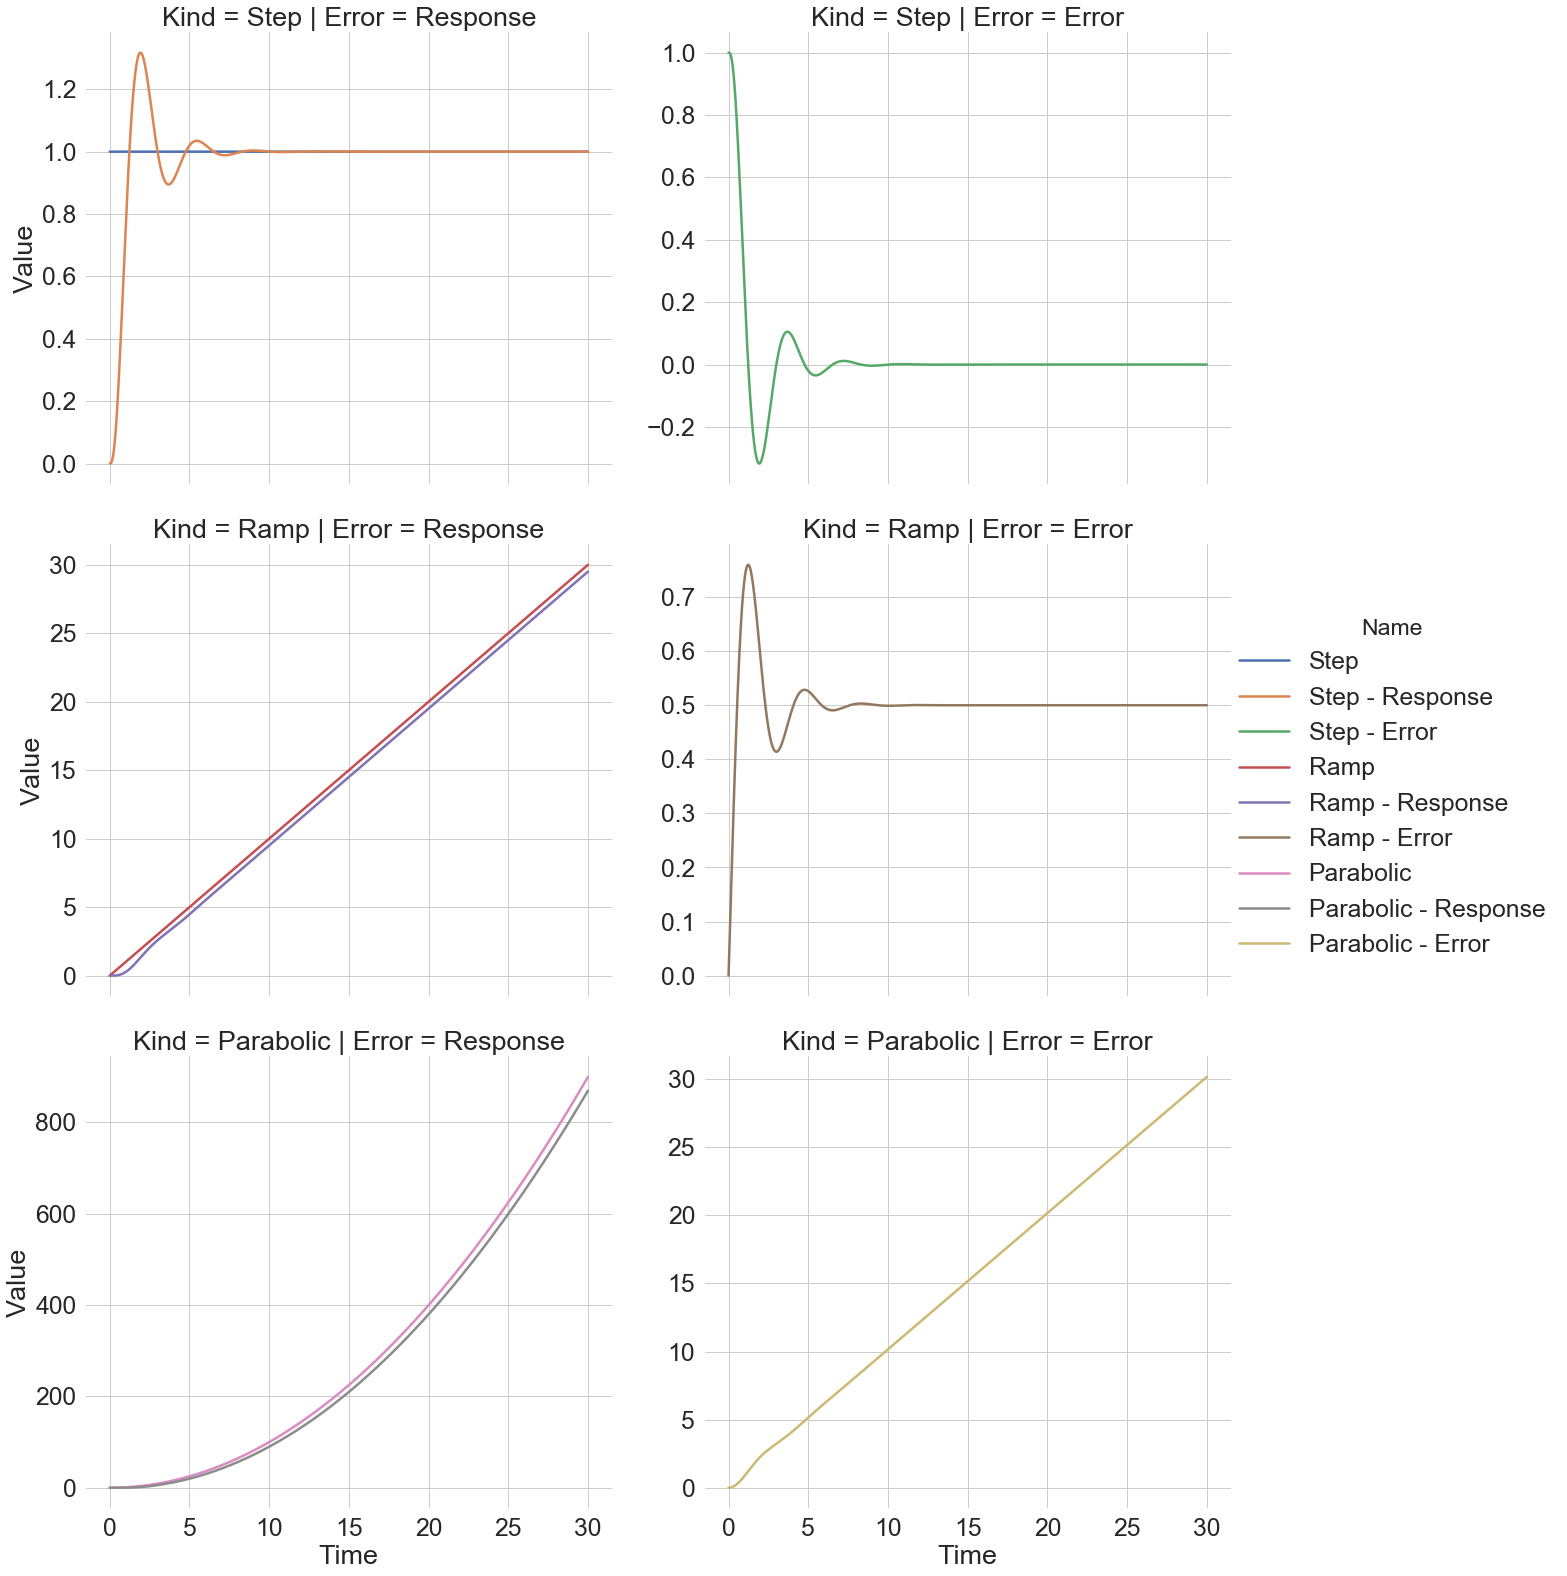

In [47]:
t = np.arange(0, 30, 0.01)
df = response_to_inputs(num, den, [step, ramp, parabola], ["Step", "Ramp", "Parabolic"], t)
create_plots(df, True);

The above errors __do__ correspond to the errors determined by looking at the steady state errors of the transfer function.

### Part (b)

I'll adjust the gain to try and reduce the ramp error without adding too much of a sinusoidal response.

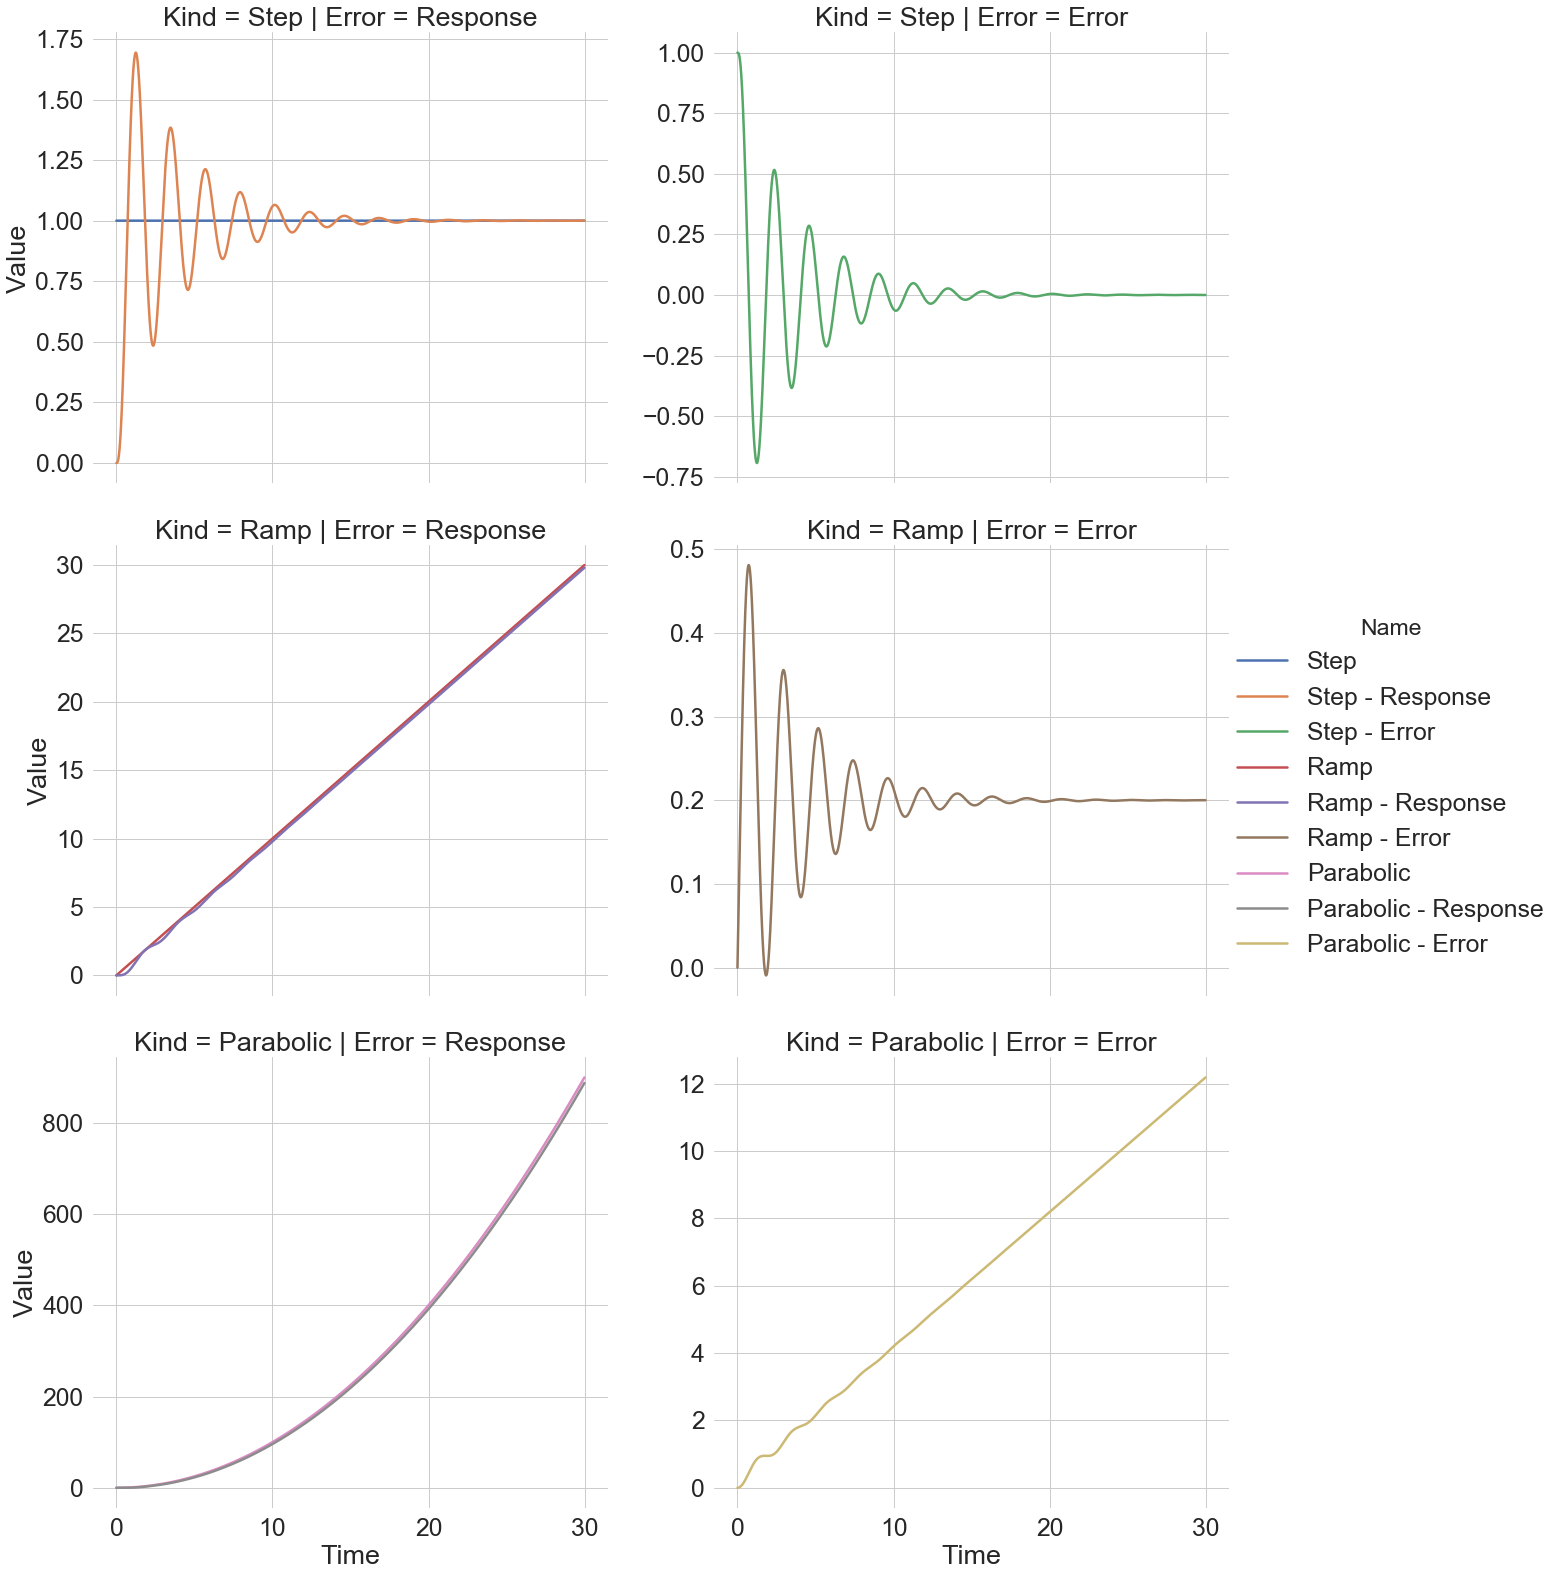

In [62]:
comp_network_num = [2.5]
comp_network_den = [1]
 
t = np.arange(0, 30, 0.01)
df = response_to_inputs(num, den, [step, ramp, parabola],
                        ["Step", "Ramp", "Parabolic"], t, comp_network_num, comp_network_den)
create_plots(df, True);

Without being given specifics on what is 'unacceptable' behavior for this system, I am concluding that reducing the steady state ramp error to 0.2 is adequate, and the response's sinusoidal behavior is acceptable.

## Problem 7.6.1


Crossover at 26.856 (rad/s) has a phase-margin of 37.060 degrees


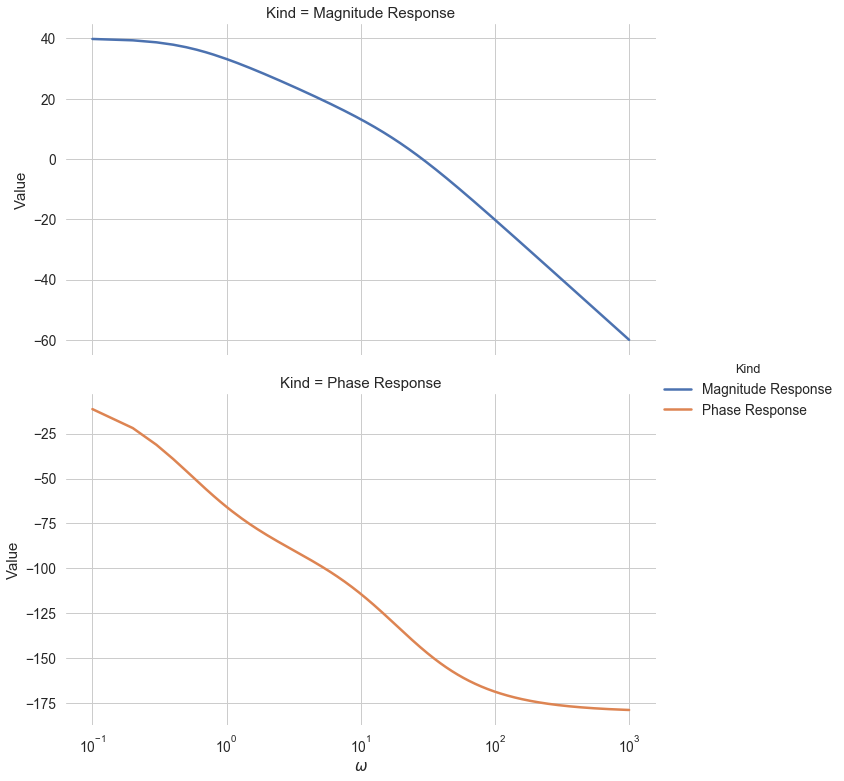

In [97]:
num = [10 ** 3]
den = [1, 20, 10]
gain_num, gain_den = [1], [1]

df, phase_margin, crossover_w = magnitude_phase_response(num, den, [0.1, 10 ** 3], 0.1, gain_num, gain_den)
print ("Crossover at {:.3f} (rad/s) has a phase-margin of {:.3f} degrees".format(crossover_w, phase_margin))
create_plots(df);

In [119]:
df[(df["Value"] <= -2.76) & (df["Value"] >= -2.77)]

,$\omega$,Value,Kind
4021,40.31,-2.760857,Magnitude Response
4022,40.32,-2.764294,Magnitude Response
4023,40.33,-2.767730,Magnitude Response


In order to design a phase margin of 50 degrees, I'll do the following:

$$\alpha = \frac{1+sin(50^o - 37.06^o + 5)}{1-sin(50^o - 37.06^o + 5)} = 1.89 = -2.765 dB$$

Thus,

$$\omega _m \approx 40.32 \frac{rad}{s}$$

$$\omega _p = \omega _m \cdot \sqrt \alpha = 55.43$$

$$\omega _z = \frac{\omega _m}{\sqrt \alpha} = 29.33$$

Therefore, the total transfer function of the gain compensation network is defined as:

$$G_c(s)=\frac{55.43}{29.33}\cdot \frac{s+29.33}{s+55.43}$$


Crossover at 30.934 (rad/s) has a phase-margin of 50.519 degrees


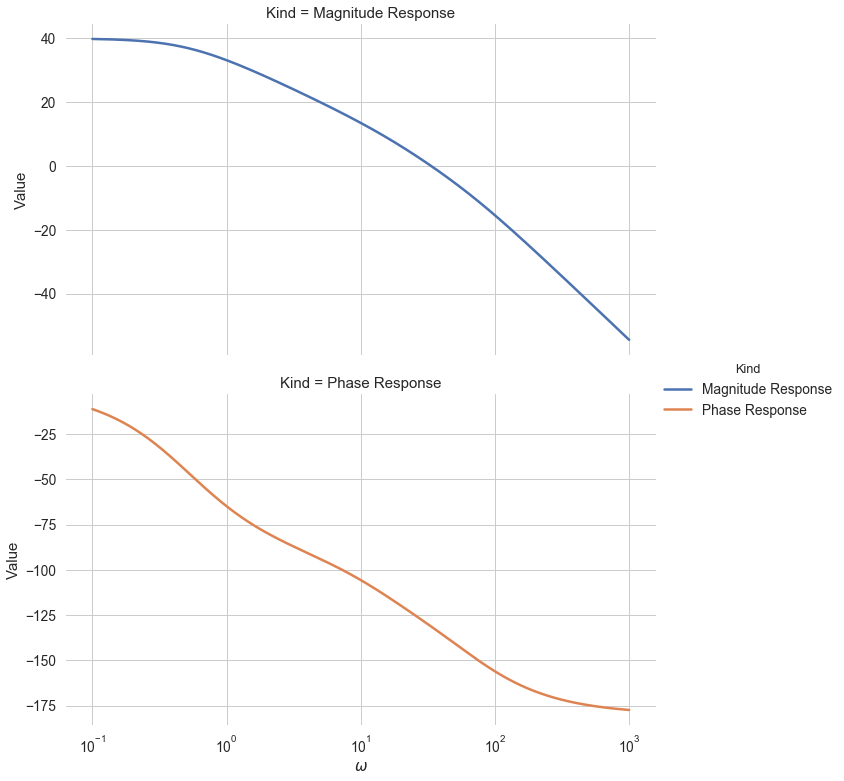

In [120]:
num = [10 ** 3]
den = [1, 20, 10]
gain_num = np.multiply(55.43, [1, 29.33])
gain_den = np.multiply(29.33, [1, 55.43])

df, phase_margin, crossover_w = magnitude_phase_response(num, den, [0.1, 10 ** 3], 0.01, gain_num, gain_den)
print ("Crossover at {:.3f} (rad/s) has a phase-margin of {:.3f} degrees".format(crossover_w, phase_margin))
create_plots(df);

Given the previously computed $G_c(s)$, the new phase margin is $50.519^o$, which was what was requested.

## Problem 7.6.5

I will start with a simple compensation network with a gain of 65, as this should reduce the parabolic error at one second to less than 1%.

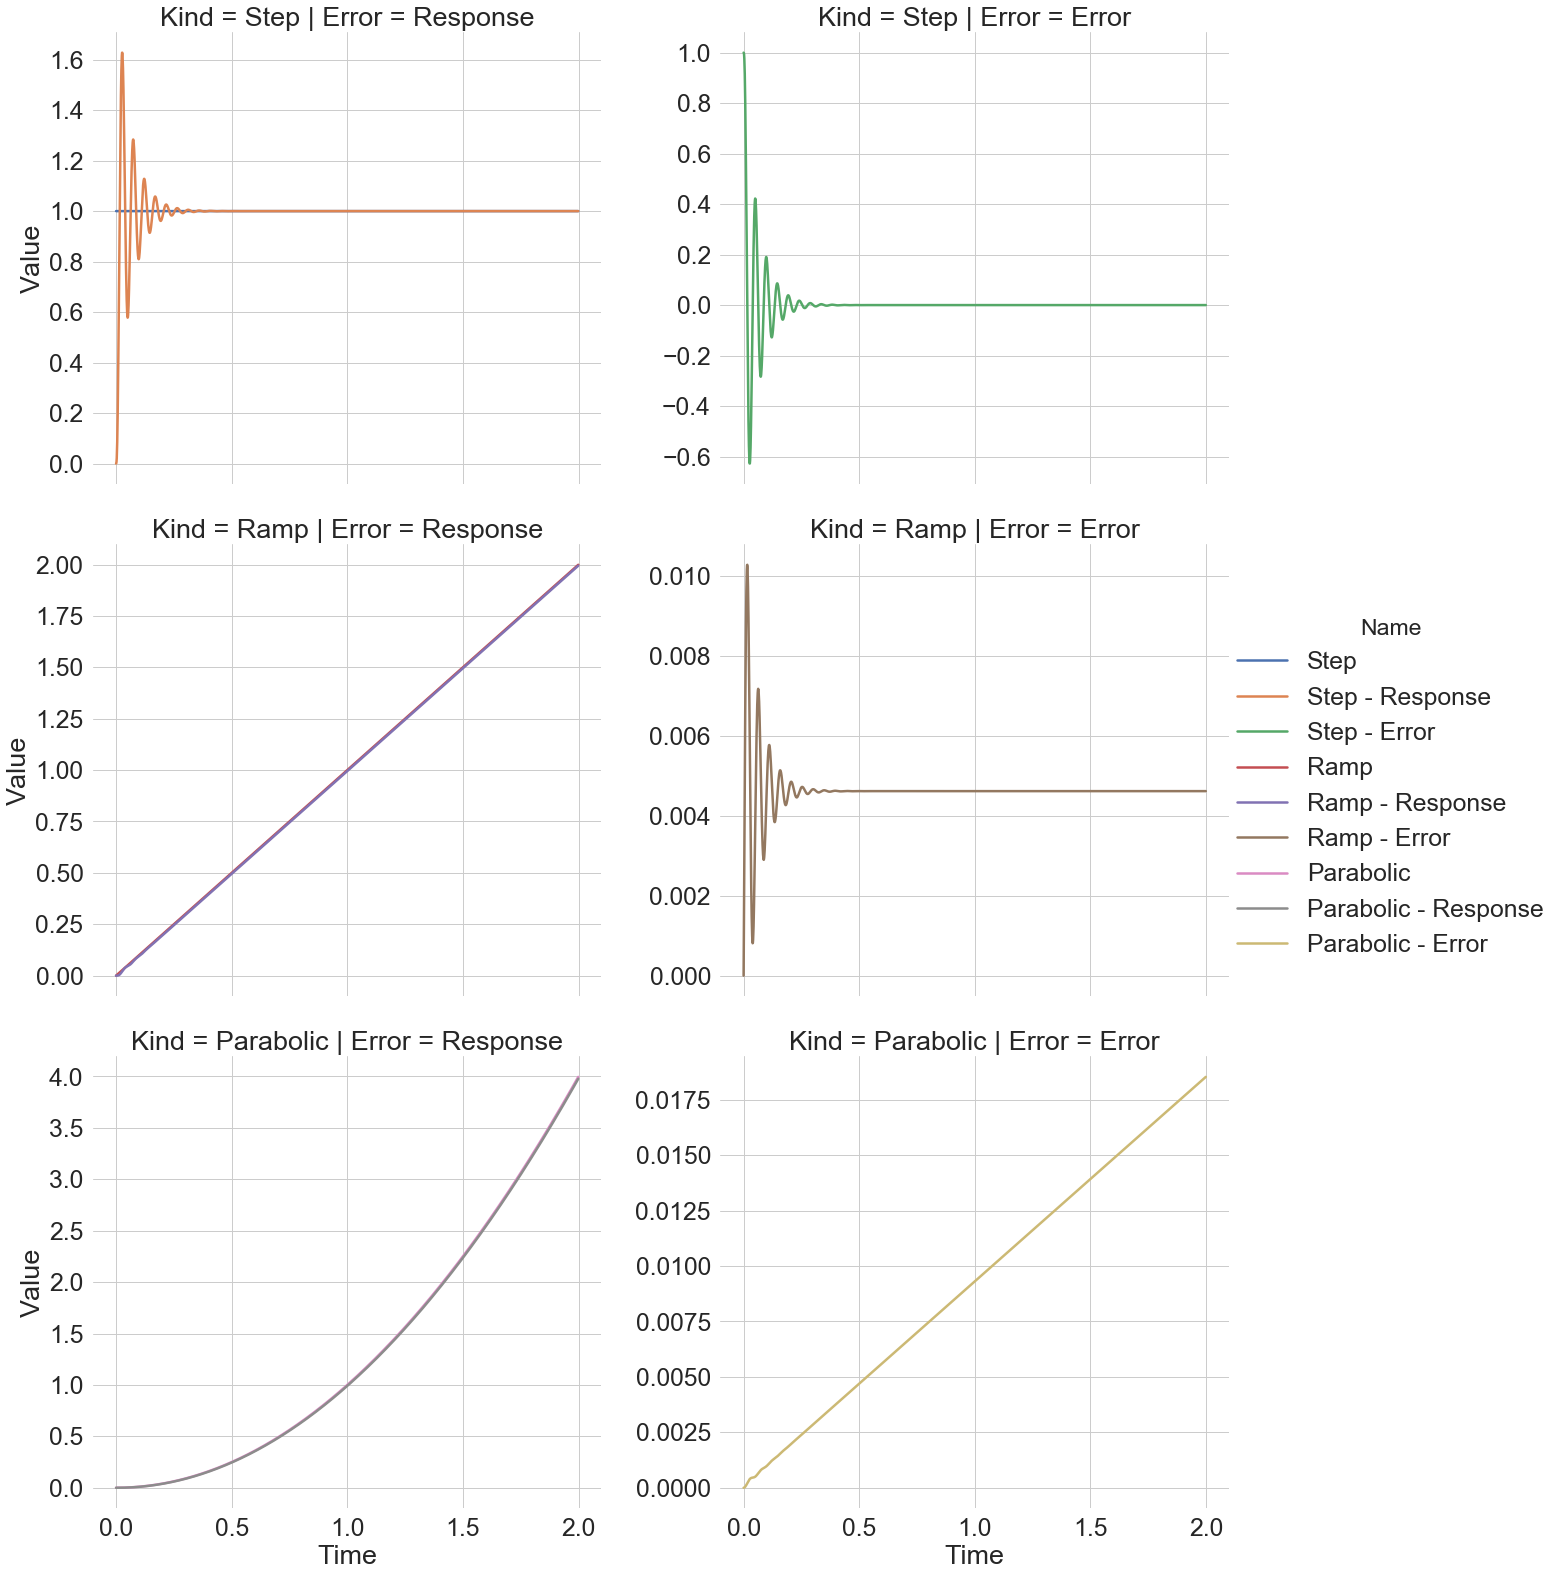

In [143]:
num = [10 ** 5]
den = convolve_all([[1, 0], [1, 100], [1, 300]])
comp_num = np.multiply(65, [1])
comp_den = [1]
 
t = np.arange(0, 2, 0.001)
df = response_to_inputs(num, den, [step, ramp, parabola],
                        ["Step", "Ramp", "Parabolic"], t, comp_num, comp_den)
create_plots(df, True);

However, this results in unacceptable oscillation for the step response. To combat this, I'll add a phase lead component to this compensation network.

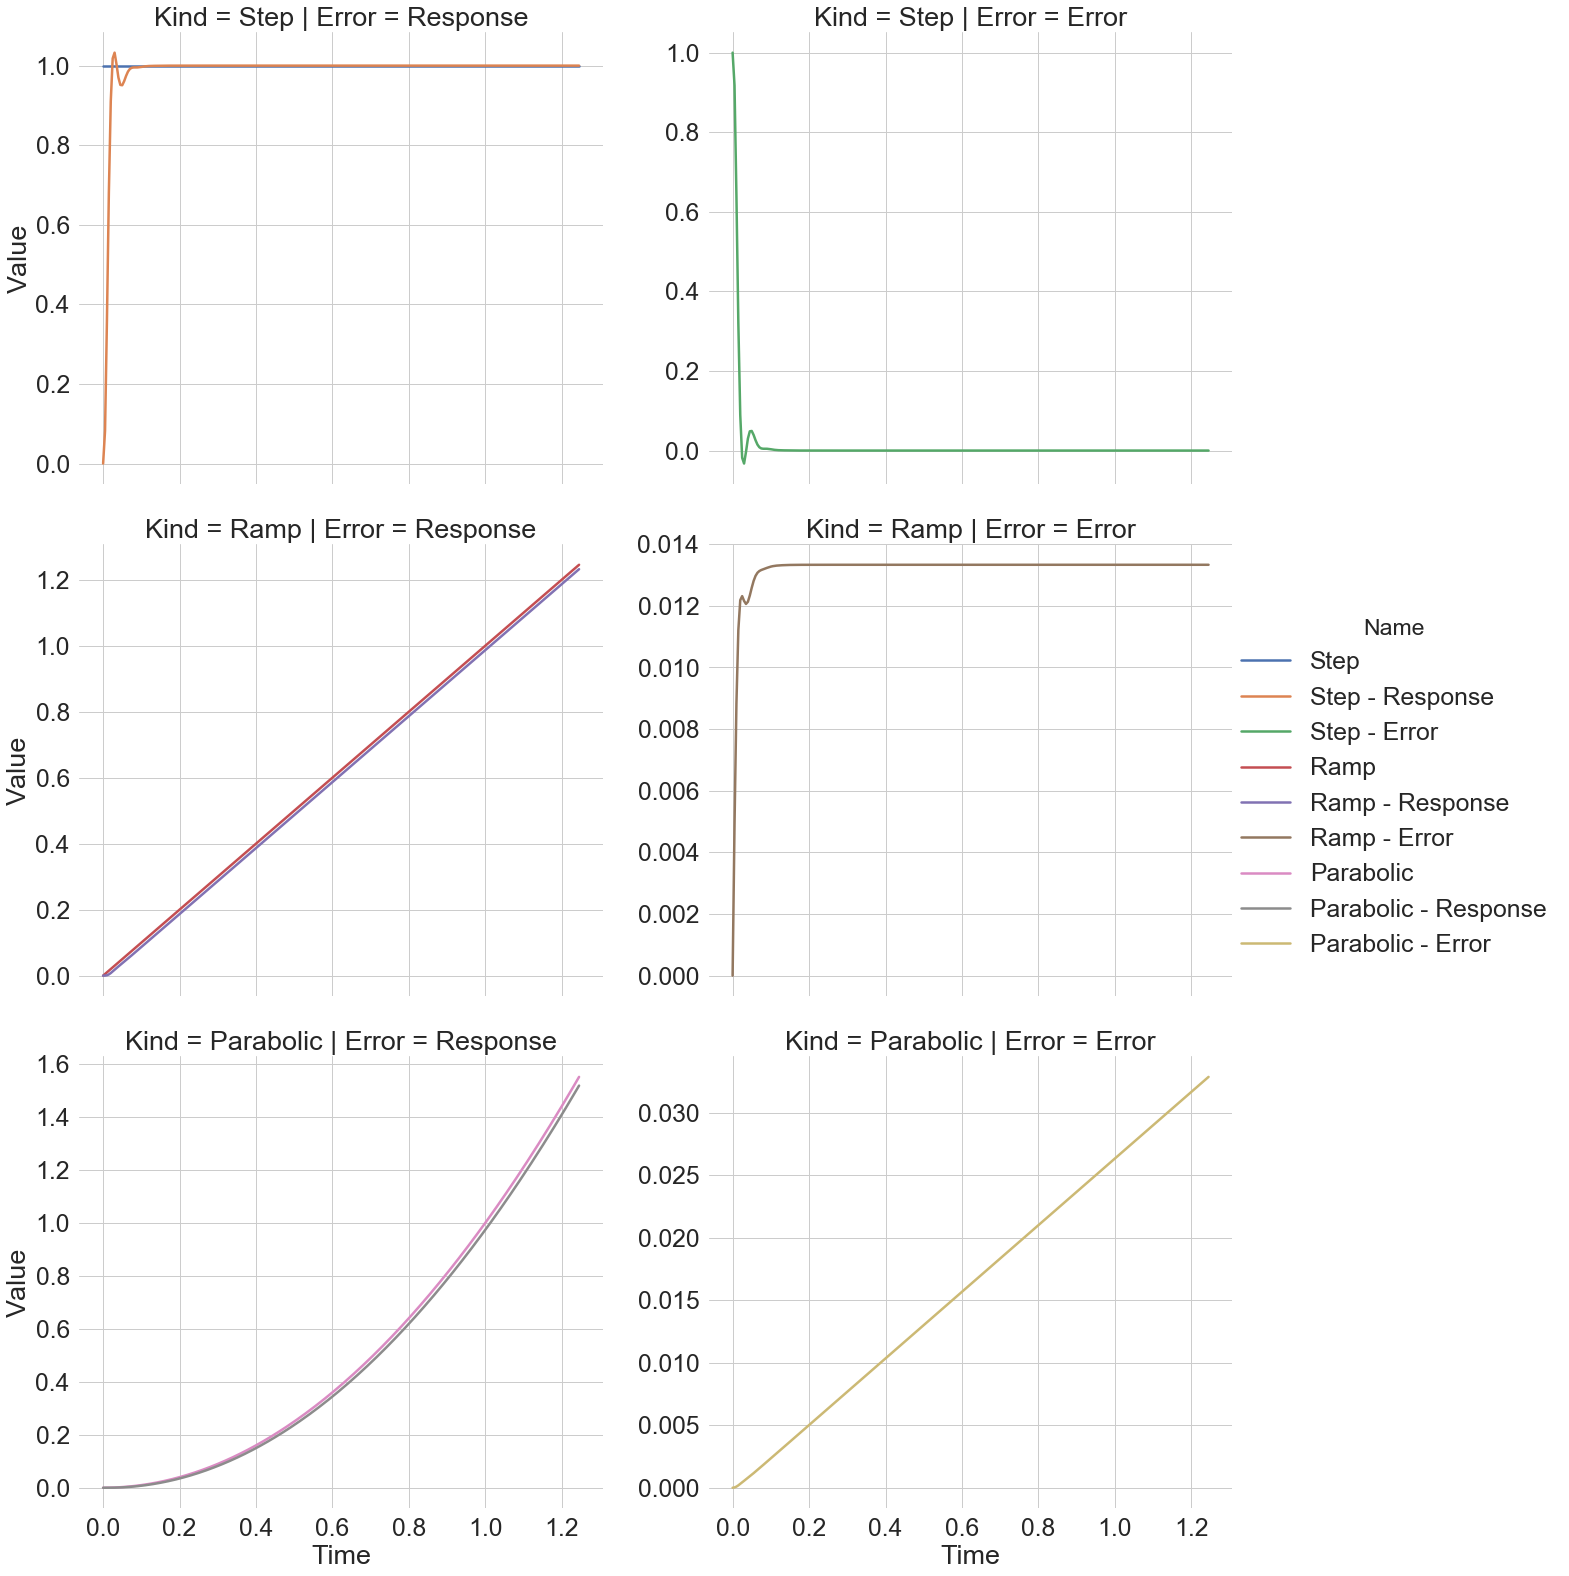

In [171]:
num = [10 ** 5]
den = convolve_all([[1, 0], [1, 100], [1, 300]])
comp_num = np.multiply(75, [1, 60])
comp_den = [1, 200]
 
t = np.arange(0, 1.25, 0.005)
df = response_to_inputs(num, den, [step, ramp, parabola],
                        ["Step", "Ramp", "Parabolic"], t, comp_num, comp_den)
create_plots(df, True);

After some trial and error, the below listed compensation network gives me a parabolic response error of less than 1% by 1 second, the overshoot to the step response is less than 10%, and settles to less than 1% within 0.05 seconds.

The network is characterized by:

$$H_c(s)=75\cdot \frac{s + 60}{s +200}$$